In [2]:
import os
import uproot
import vector
import awkward as ak
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

vector.register_awkward()

Let's look at this dataset: [SingleMuon primary dataset in NANOAOD format from RunH of 2016](https://opendata.cern.ch/record/30563)

[Variable list](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAOD/30563/SingleMuon_doc.html)

In [3]:
datafile_name = '576759DA-4A35-534B-B926-2A9E4A5A7268.root'

if not (os.path.isfile(datafile_name)): 
    ! curl -O http://opendata.cern.ch//eos/opendata/cms/Run2016H/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/1210000/576759DA-4A35-534B-B926-2A9E4A5A7268.root


In [4]:
infile = uproot.open(datafile_name)

In [5]:
events = infile['Events']

df = events.arrays(
    filter_name="/(run|event|luminosityBlock|Muon_|nMuon|MET_|Electron_|nElectron)/", 
    library='ak'
) 

len(df)

56141

In [6]:
df

<Array [{run: 283830, ...}, {...}, ..., {...}] type='56141 * {run: uint32, ...'>

Selections:

* $p_{t} >$ 25 GeV
* $|\eta|$ < 2.4
* $I_{PF} / p_{t}$ < 0.15
* $m_{T}$ > 40 GeV, where $m_{T} = \sqrt{2p_{t}^{l}p_{t}^{\nu}[1-cos(\Delta\phi)]}$
* reject if another muon or electron with $p_{t} > 10 GeV$

Let's reject events with even one electron and more than one muon

In [7]:
df = df[(df['nMuon'] == 1) & (df['nElectron'] == 0)]
len(df)

36840

Text(0.5, 0, 'muon eta')

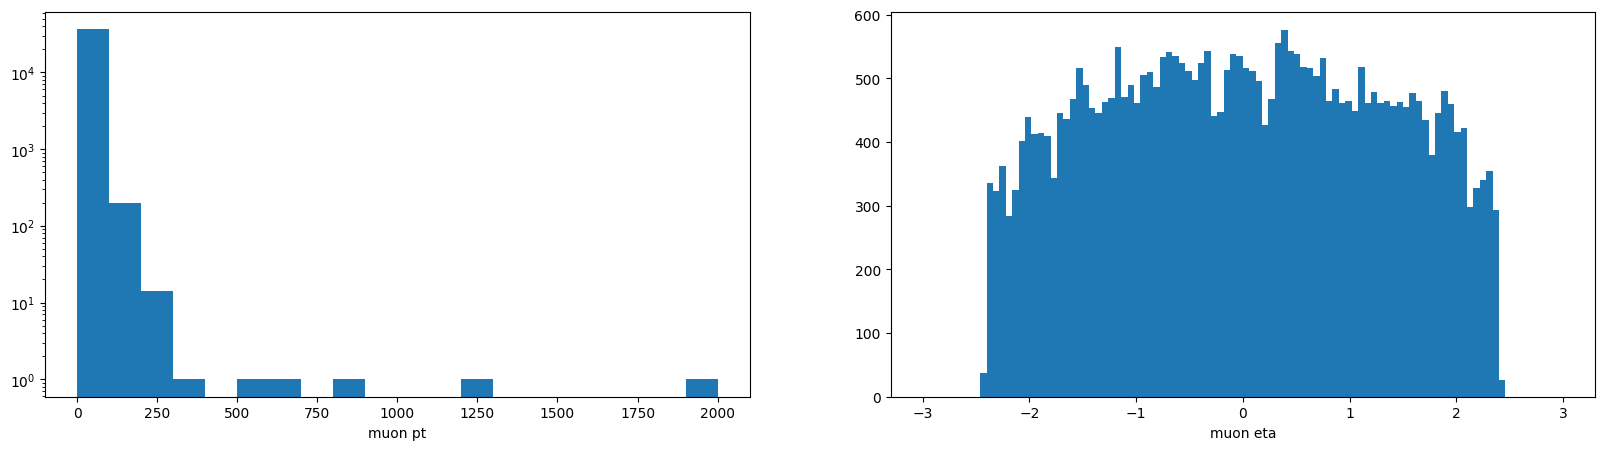

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

axes[0].hist(ak.flatten(df['Muon_pt']), bins=20, range=(0,2000))
axes[0].set_xlabel('muon pt')
axes[0].set_yscale('log')

axes[1].hist(ak.flatten(df['Muon_eta']), bins=100, range=(-3,3))
axes[1].set_xlabel('muon eta')

In [9]:
df['Muon_iso'] = df['Muon_pfRelIso04_all'] / df['Muon_pt']

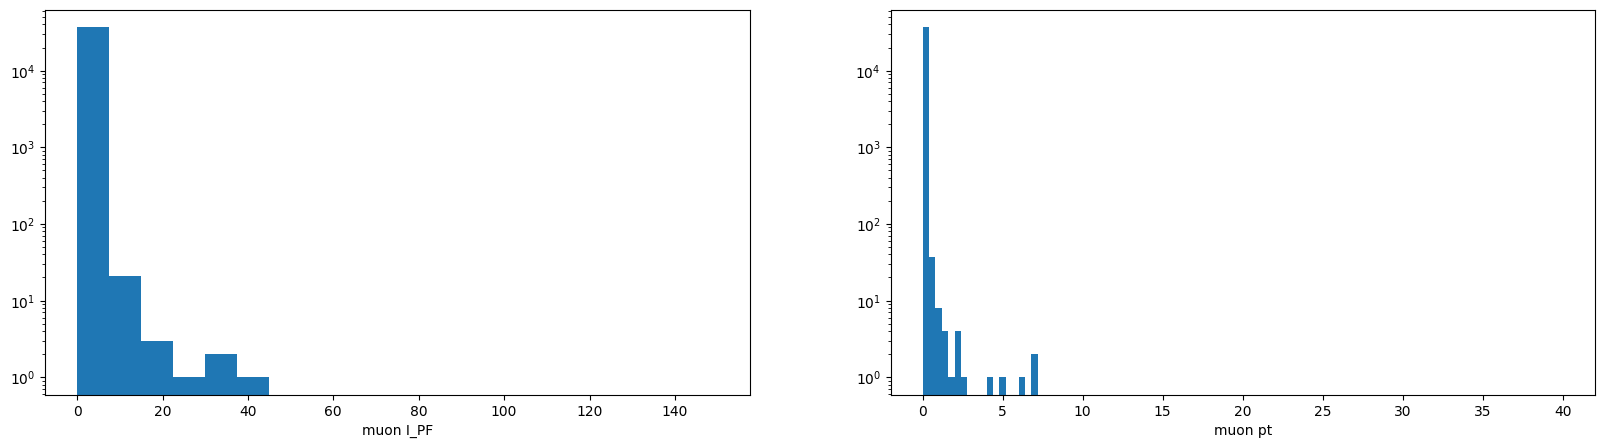

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

axes[0].hist(ak.flatten(df['Muon_pfRelIso04_all']), bins=20, range=(0,150))
axes[0].set_xlabel('muon I_PF')
axes[0].set_yscale('log')

axes[1].hist(ak.flatten(df['Muon_iso']), bins=100, range=(0,40))
axes[1].set_xlabel('muon pt')
axes[1].set_yscale('log')

In [11]:
pt_cut = ak.flatten(df['Muon_pt'] > 25)
eta_cut = ak.flatten(np.abs(df['Muon_eta']) < 2.4)

In [12]:
df = df[pt_cut & eta_cut]
len(df)

27284

Text(0.5, 0, 'muon eta')

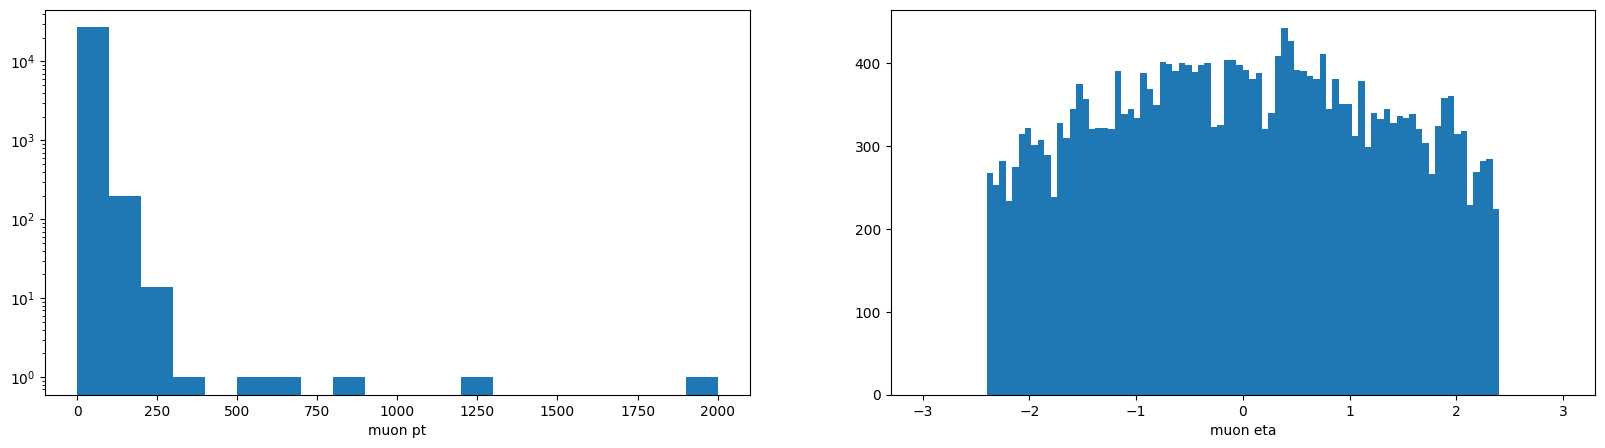

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

axes[0].hist(ak.flatten(df['Muon_pt']), bins=20, range=(0,2000))
axes[0].set_xlabel('muon pt')
axes[0].set_yscale('log')

axes[1].hist(ak.flatten(df['Muon_eta']), bins=100, range=(-3,3))
axes[1].set_xlabel('muon eta')

In [14]:
df['M_t'] = np.sqrt(
    2*df['Muon_pt']*df['MET_pt']*(1-np.cos(df['Muon_phi']-df['MET_phi']))
)

Text(0.5, 0, 'M_t')

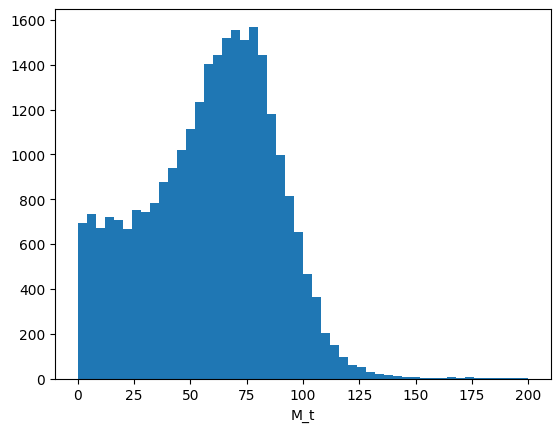

In [15]:
plt.hist(ak.flatten(df['M_t']), bins=50, range=(0,200))
plt.xlabel('M_t')

In [16]:
iso_cut = ak.flatten(df['Muon_iso'] < 0.15)

df = df[iso_cut]
len(df)

27257

In [17]:
mt_cut = ak.flatten(df['M_t'] > 40)
df = df[mt_cut]

Text(0.5, 0, 'M_t')

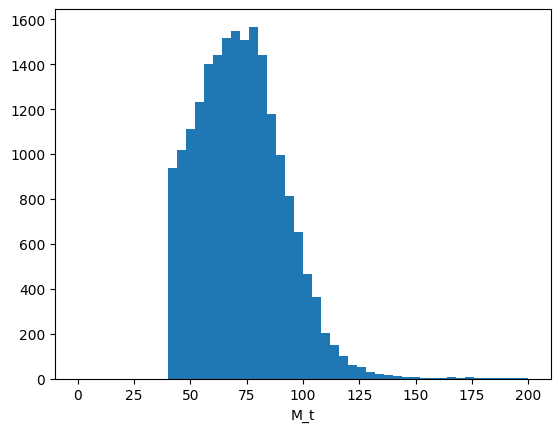

In [18]:
plt.hist(ak.flatten(df['M_t']), bins=50, range=(0,200))
plt.xlabel('M_t')

In [19]:
len(df)

19917

In [36]:
d = {
    'Run': ak.flatten(df['run'], axis=0),
    'Event': ak.flatten(df['event'], axis=0),
    'Lumi': ak.flatten(df['luminosityBlock'], axis=0),
    'pt': ak.flatten(df['Muon_pt'], axis=1),
    'phi': ak.flatten(df['Muon_phi'], axis=1),
    'eta': ak.flatten(df['Muon_eta'], axis=1),
    'Q': ak.flatten(df['Muon_charge'], axis=1),
    'MET': ak.flatten(df['MET_pt'], axis=0),
    'phiMET': ak.flatten(df['MET_phi'], axis=0),
    'Mt': ak.flatten(df['M_t'], axis=1)
}

pdf = pd.DataFrame(d)

pdf

,Run,Event,Lumi,pt,phi,eta,Q,MET,phiMET,Mt
0,283830,28246124,15,26.081926,-2.238770,1.983643,1,41.130352,0.529907,64.370575
1,283830,28832584,15,25.179100,0.622559,0.976440,-1,17.666527,-2.270020,41.855324
2,283830,27953541,15,33.776405,1.079346,-1.939697,1,16.113462,-2.569336,45.166840
3,283830,28011942,15,40.445992,0.766479,-0.583130,1,39.285496,-2.698730,78.681656
4,283830,29338909,15,34.520691,0.243896,1.098633,-1,67.532845,-2.937988,96.547073
...,...,...,...,...,...,...,...,...,...,...
19912,283830,202492859,108,39.561298,1.139160,-2.054688,-1,35.823517,-2.480469,73.151611
19913,283830,203802769,108,27.348377,-2.846680,0.832397,1,71.625336,0.064072,87.928535
19914,283830,203099634,108,30.215282,0.242249,1.304688,-1,27.441610,2.566406,52.846512
19915,283830,204094187,108,39.339905,2.747070,-1.907959,1,24.248846,-0.303589,61.708237


In [38]:
pdf.to_csv(
    'SingleMuonRun2016H.csv',
    index=False
)